In [1]:
import pandas as pd
import data_collection as dc
import prediction_model as pm
import sklearn.metrics as metrics
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import datetime
import talos
import math
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [2]:
def add_lag_diff(df, begin, end, interval, dropna=True):
    df_lag = df.copy()
    columns = df.columns
    for column in columns:
        if column.lower() == 'date':
            continue
        for i in range(begin, end, interval):
            df_lag[f'{column}_{i}_lag'] = df_lag[column].shift(i)  # lags in days
            df_lag[f'{column}_{i}_diff'] = df_lag[f'{column}_{i}_lag'].diff()  # difference
    return df_lag.dropna() if dropna else df_lag

In [2]:
geo = "BE"
url_trends = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/data/trends/model/"
url_hospi = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/src/be-covid-hospi.csv"
full_data = pm.create_full_df(url_trends, url_hospi, geo)
full_data = full_data.reset_index().set_index('DATE')
full_data = full_data.drop(columns=['LOC'])
full_data = full_data.dropna()
full_data

,HOSP,/m/0cjf0,/m/0b76bty,/m/01cdt5,/m/05sfr2,/m/0m7pl,/m/01cpyy,/m/0g9pc,/g/1213j0cz,/m/0hn9s,/m/01b_06,/m/07mf1,/m/01c751,/m/0lbt3,/m/02gy9_,/m/01b_21
DATE,,,,,,,,,,,,,,,,
2020-03-01,0,28.0,49.0,68.0,0.0,9.0,27.0,49.0,0.0,19.0,47.0,19.0,28.0,21.0,36.0,42.0
2020-03-02,0,30.0,27.0,65.0,0.0,0.0,32.0,52.0,8.0,20.0,46.0,22.0,28.0,13.0,63.0,40.0
2020-03-03,0,26.0,23.0,39.0,0.0,0.0,28.0,45.0,31.0,20.0,45.0,19.0,29.0,18.0,20.0,39.0
2020-03-04,0,22.0,41.0,17.0,0.0,0.0,27.0,45.0,26.0,17.0,39.0,27.0,16.0,14.0,32.0,34.0
2020-03-05,0,33.0,42.0,17.0,0.0,0.0,31.0,50.0,13.0,24.0,43.0,15.0,19.0,18.0,20.0,44.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-14,255,18.0,36.0,12.0,70.0,18.0,16.0,4.0,18.0,9.0,35.0,24.0,7.0,13.0,34.0,17.0
2020-10-15,284,21.0,17.0,12.0,60.0,0.0,16.0,6.0,19.0,12.0,39.0,33.0,12.0,18.0,39.0,24.0
2020-10-16,240,25.0,28.0,25.0,37.0,19.0,27.0,6.0,19.0,12.0,34.0,21.0,9.0,12.0,31.0,22.0


In [3]:
geo = "BE"
url_trends = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/data/trends/model/"
url_hospi = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/data/hospi/be-covid-hospi.csv"
full_df = pm.create_df_trends_url(url_hospi, geo)
full_data, full_data_no_rolling = pm.google_trends_process(full_df, pm.list_topics, start_year=2020, start_mon=2,
                                                           stop_year=2020,
                                                          stop_mon=9, step=1, data_collection=False)
shifted_df = add_lag_diff(full_data, 7, 14, 1)
shifted_df = shifted_df.reset_index().set_index('DATE')
shifted_df = shifted_df.drop(columns=['LOC'])
shifted_df

DL BE Fièvre
DL BE Mal de gorge
DL BE Dyspnée
DL BE Agueusie
DL BE Anosmie
DL BE Coronavirus
DL BE Virus
DL BE Température corporelle humaine
DL BE Épidémie
DL BE Symptôme
DL BE Thermomètre
DL BE Grippe espagnole
DL BE Paracétamol
DL BE Respiration
DL BE Toux


,Fièvre,Mal de gorge,Dyspnée,Agueusie,Anosmie,Coronavirus,Virus,Température corporelle humaine,Épidémie,Symptôme,...,HOSP_CORR_9_lag,HOSP_CORR_9_diff,HOSP_CORR_10_lag,HOSP_CORR_10_diff,HOSP_CORR_11_lag,HOSP_CORR_11_diff,HOSP_CORR_12_lag,HOSP_CORR_12_diff,HOSP_CORR_13_lag,HOSP_CORR_13_diff
DATE,,,,,,,,,,,,,,,,,,,,,
2020-03-18,0.875211,0.666075,1.000000,-0.054230,-0.030120,0.709091,0.609756,0.513514,0.596522,0.615764,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-03-19,0.726813,0.531083,0.712984,0.162690,0.337349,0.619835,0.480836,0.243243,0.506087,0.467980,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-03-20,0.591906,0.460036,0.485194,0.158351,0.638554,0.533884,0.393728,0.360360,0.426087,0.313629,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-03-21,0.433390,0.349911,0.271071,0.353579,0.795181,0.441322,0.306620,0.346847,0.370435,0.218391,...,0.018057,0.018057,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-03-22,0.328836,0.275311,0.271071,0.644252,0.921687,0.368595,0.236934,0.247748,0.325217,0.175698,...,0.040946,0.022889,0.018057,0.018057,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-11,-0.430017,-0.207815,-0.189066,0.388286,-0.331325,-0.666116,-0.874564,-0.495495,-0.878261,-0.264368,...,0.144201,0.006612,0.137589,0.010173,0.127416,0.005595,0.121821,-0.001526,0.123347,0.001017
2020-10-12,-0.463744,-0.253996,-0.184510,0.453362,-0.433735,-0.656198,-0.871080,-0.486486,-0.850435,-0.218391,...,0.149288,0.005086,0.144201,0.006612,0.137589,0.010173,0.127416,0.005595,0.121821,-0.001526
2020-10-13,-0.446880,-0.229130,-0.125285,0.505423,-0.433735,-0.609917,-0.871080,-0.445946,-0.808696,-0.208539,...,0.161495,0.012208,0.149288,0.005086,0.144201,0.006612,0.137589,0.010173,0.127416,0.005595


In [12]:
X_train = shifted_df[:'2020-09-15'].drop(['HOSP_CORR'], axis = 1)
y_train = shifted_df.loc[:'2020-09-15', 'HOSP_CORR']
X_test = shifted_df['2020-09-16':].drop(['HOSP_CORR'], axis = 1)
y_test = shifted_df.loc['2020-09-16':, 'HOSP_CORR']

In [13]:
models = []
models.append(('LR', LinearRegression()))
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
    tscv = TimeSeriesSplit(n_splits=10)
    cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='neg_mean_absolute_error')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))


LR: -0.048522 (0.038624)


(196.0, 211.0)

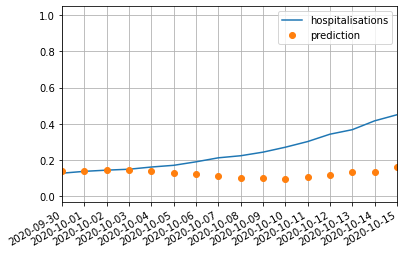

In [14]:
pred = models[0][1].fit(X_train, y_train)
x = pd.concat([X_train, X_test], axis=1).index
y = pd.concat([y_train, y_test], axis=0)
x_pred = X_test.index
y_pred = pred.predict(X_test)
# plot the actual hospitalisations and predictions
fig = plt.figure()
plt.plot(x, y, label='true hospitalisations')
plt.plot(x_pred, y_pred, 'o', label='prediction')
plt.grid()
plt.legend()
x_max = str(datetime.datetime.strptime(x_pred.max(), '%Y-%m-%d').date())
delay = datetime.timedelta(days = 15)
x_min = str((datetime.datetime.strptime(x.max(), '%Y-%m-%d') - delay).date())
fig.autofmt_xdate()
plt.xlim([x_min, x_max])

In [7]:
def create_model(_, _2, _3, _4, p):
    """
    Trains the sequential model with all the train_datapoints and saves this model.
    :param _: X training datapoints
    :param _2: Y training datapoints
    :param _3: X validation datapoints
    :param _4: Y validation datapoints
    :param p: hyper parameters to evaluate
    :return: history : a history object containing a dictionary of all loss values and other metric values.
    :return: model : the sequential trained model
    """
    session_conf = pm.tf.compat.v1.ConfigProto(intra_op_parallelism_threads=8, inter_op_parallelism_threads=8)
    pm.tf.compat.v1.set_random_seed(1)
    sess = pm.tf.compat.v1.Session(graph=pm.tf.compat.v1.get_default_graph(), config=session_conf)
    pm.tf.compat.v1.keras.backend.set_session(sess)
    
    model = pm.Sequential()
    model.add(pm.LSTM(p["n_lstm_node_first"], return_sequences=True, input_shape=(None, pm.n_features),
                   kernel_regularizer=p['reg'](p['regw'])))
    if p["n_lstm_node_second"] != 0:
        model.add(pm.LSTM(p["n_lstm_node_second"], return_sequences=True, kernel_regularizer=p['reg'](p['regw'])))
    for _ in range(p["n_layers_after"]):
        model.add(pm.TimeDistributed(pm.Dense(p["n_node_hidden_layers"], kernel_regularizer=p['reg'](p['regw']),
                                        activation=p['activation'])))
    model.add(pm.TimeDistributed(pm.Dense(1, kernel_regularizer=p['reg'](p['regw']))))

    model.compile(loss=p["losses"], optimizer=p["optimizer"], metrics=['mae', 'mse'])

    # With TensorFlow version 2.2 or higher, the fit function works exactly as the fit_generator function
    # Not everything is stocked into the RAM
    history = model.fit(train_generator(), steps_per_epoch=len(train_data), epochs=p["epochs"], verbose=0, shuffle=False,
                        validation_data=validation_generator(), validation_steps=len(valid_data))


    return history, model

In [8]:
def train_generator():
    """
    Creates a generator for the datapoints used for the training
    :return: a generator containing the datapoints for the training
    """
    while True:
        d = np.random.randint(0, 20)
        yield train_data[0][d:], train_data[1][d:]


def validation_generator():
    """
    Creates a generator for the datapoints used for the validation
    :return: a generator containing the datapoints for the validation
    """
    while True:
        yield valid_data



In [11]:
train_data = {}
valid_data = {}
test_data = {}
full_datapoints = {} 

x, y = pm.create_dataset(shifted_df.values, look_back=3)
full_datapoints = (x, y)
assert pm.n_features == -1 or pm.n_features == x.shape[-1]
pm.n_features = x.shape[-1]

x, y = full_datapoints
length = x.shape[0]
train_len = int(length * pm.train_ratio)
valid_len = int(length * pm.valid_ratio)

train_data = (x[0:train_len], y[0:train_len])
valid_data = (x[train_len:train_len + valid_len], y[train_len:train_len + valid_len])
test_data = (x[train_len + valid_len:], y[train_len + valid_len:])

p = pm.define_parameters()

scan_object = talos.Scan(
            x=[],
            y=[],
            x_val=[],
            y_val=[],
            params=p,
            model=create_model,
            experiment_name='trends1',
            fraction_limit=0.01
        )

analyze_object = talos.Analyze(scan_object)
print("MAE", analyze_object.low('mae'))
print("MSE", analyze_object.low('mse'))
print("VAL MAE", analyze_object.low('val_mae'))
print("VAL MSE", analyze_object.low('val_mse'))
analyze_object.table('val_mse', exclude=[], ascending=True)

# Finding the model that minimises the value of the MSE
best_model = scan_object.best_model('val_mse', asc=True)



  0%|          | 0/233 [03:50<?, ?it/s]


  0%|          | 1/233 [00:16<1:02:10, 16.08s/it]

KeyboardInterrupt: 